In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as proportion
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import statsmodels.stats.power as smp
from statsmodels.stats.multitest import multipletests
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

def connect(query):
    connection = psycopg2.connect(database = os.getenv('PC_DB'),
                                  user = os.getenv('PC_USERNAME'),
                                  password = os.getenv('PC_PASSWORD'),
                                  host = os.getenv('PC_HOST'),
                                  port = os.getenv('PC_PORT'))
    cursor = connection.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    columns = []
    for col in cursor.description:
        columns.append(col[0])
    df = pd.DataFrame(result, columns = columns)
    return df

purchases = connect("""SELECT * FROM purchases""")
registration = connect("""SELECT * FROM registration""")

from clickhouse_driver import Client

client = Client(os.getenv('CH_IP'),
                database = os.getenv('CH_DB'),
                password = os.getenv('CH_PASS'),
                port = os.getenv('CH_PORT'),
                user= os.getenv('CH_USERNAME'),
                verify = False)
result, columns = client.execute('SELECT * FROM new_events', with_column_types=True)
col = []
for desc in columns:
    col.append(desc[0])
new_events = pd.DataFrame(result,columns=col)

In [3]:
new_events

,user_id,timestamp,test_group,event
0,1256666,2020-11-19 12:14:20,big_increase,registration
1,1225937,2020-11-23 03:37:05,small_increase,registration
2,1265347,2020-11-19 16:15:57,small_increase,registration
3,1332763,2020-11-06 03:10:02,small_increase,registration
4,1317792,2020-11-17 00:45:55,control,registration
...,...,...,...,...
327165,1268139,2020-11-19 15:11:26,small_increase,registration
327166,1336773,2020-11-17 13:01:38,small_increase,registration
327167,1400394,2020-11-17 18:05:28,control,registration
327168,1210538,2020-11-09 20:40:37,small_increase,registration


In [116]:
new_events_1 = new_events[['user_id','test_group']].copy()
new_events_1 = new_events_1.drop_duplicates(subset=['user_id'])

new_events = pd.merge(new_events,new_events_1,how='left',left_on='user_id',right_on='user_id')

new_events = new_events.drop(columns=['test_group_x'])
new_events.rename(columns={'test_group_y': 'test_group'}, inplace=True)
new_events

# таким образом были заполнены пустые поля в new_events['test_group'].

,user_id,timestamp,event,test_group
0,1256666,2020-11-19 12:14:20,registration,big_increase
1,1225937,2020-11-23 03:37:05,registration,small_increase
2,1265347,2020-11-19 16:15:57,registration,small_increase
3,1332763,2020-11-06 03:10:02,registration,small_increase
4,1317792,2020-11-17 00:45:55,registration,control
...,...,...,...,...
327165,1268139,2020-11-19 15:11:26,registration,small_increase
327166,1336773,2020-11-17 13:01:38,registration,small_increase
327167,1400394,2020-11-17 18:05:28,registration,control
327168,1210538,2020-11-09 20:40:37,registration,small_increase


In [117]:
new_events = pd.merge(new_events, registration, how = 'left', left_on = 'user_id', right_on= 'user_id')

In [118]:
new_events['time_to_order'] = new_events['timestamp'] - new_events['registered_at']
new_events['time_to_order'] = new_events['time_to_order'].dt.total_seconds().div(86400).astype(float)
# float значения.

new_events['time_to_order'] = new_events['time_to_order'].apply(lambda x: 'NaN' if x <= 0 else x)
# заменил пустые значения на NaN.
new_events

,user_id,timestamp,event,test_group,registered_at,device,geo,marketing,time_to_order
0,1256666,2020-11-19 12:14:20,registration,big_increase,2020-11-19 12:14:20,desktop,regions,social,NaN
1,1225937,2020-11-23 03:37:05,registration,small_increase,2020-11-23 03:37:05,desktop,world,cpc,NaN
2,1265347,2020-11-19 16:15:57,registration,small_increase,2020-11-19 16:15:57,desktop,regions,cpc,NaN
3,1332763,2020-11-06 03:10:02,registration,small_increase,2020-11-06 03:10:02,desktop,regions,organic,NaN
4,1317792,2020-11-17 00:45:55,registration,control,2020-11-17 00:45:55,mobile,regions,organic,NaN
...,...,...,...,...,...,...,...,...,...
329562,1268139,2020-11-19 15:11:26,registration,small_increase,2020-11-19 15:11:26,desktop,world,organic,NaN
329563,1336773,2020-11-17 13:01:38,registration,small_increase,2020-11-17 13:01:38,desktop,spb,referral,NaN
329564,1400394,2020-11-17 18:05:28,registration,control,2020-11-17 18:05:28,desktop,msk,organic,NaN
329565,1210538,2020-11-09 20:40:37,registration,small_increase,2020-11-09 20:40:37,mobile,msk,organic,NaN


In [119]:
only_purchase = new_events.loc[new_events['event'] == 'purchase'].copy()
only_purchase

,user_id,timestamp,event,test_group,registered_at,device,geo,marketing,time_to_order
28,1343452,2020-11-20 20:37:40,purchase,small_increase,2020-11-19 15:56:34,desktop,spb,organic,1.19521
31,1287352,2020-11-18 15:37:09,purchase,control,2020-11-13 17:30:22,mobile,msk,organic,4.92138
35,1276338,2020-11-27 04:30:56,purchase,control,2020-11-24 03:25:42,desktop,regions,organic,3.0453
57,1291792,2020-11-24 13:28:05,purchase,big_increase,2020-11-23 02:30:08,desktop,world,organic,1.45691
64,1397741,2020-11-17 12:13:37,purchase,control,2020-11-13 10:29:43,desktop,msk,cpc,4.07215
...,...,...,...,...,...,...,...,...,...
329530,1400795,2020-11-09 14:44:50,purchase,big_increase,2020-11-09 10:45:59,mobile,regions,cpc,0.165868
329533,1223473,2020-11-13 08:55:06,purchase,control,2020-11-12 14:40:09,tablet,spb,social,0.760382
329542,1177147,2020-11-11 22:14:44,purchase,big_increase,2020-11-11 16:09:26,desktop,regions,organic,0.253681
329546,1248667,2020-11-07 14:45:38,purchase,big_increase,2020-11-04 05:18:36,mobile,msk,organic,3.39377


In [120]:
np.percentile(only_purchase['time_to_order'], 90)

4.563645833333333

C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


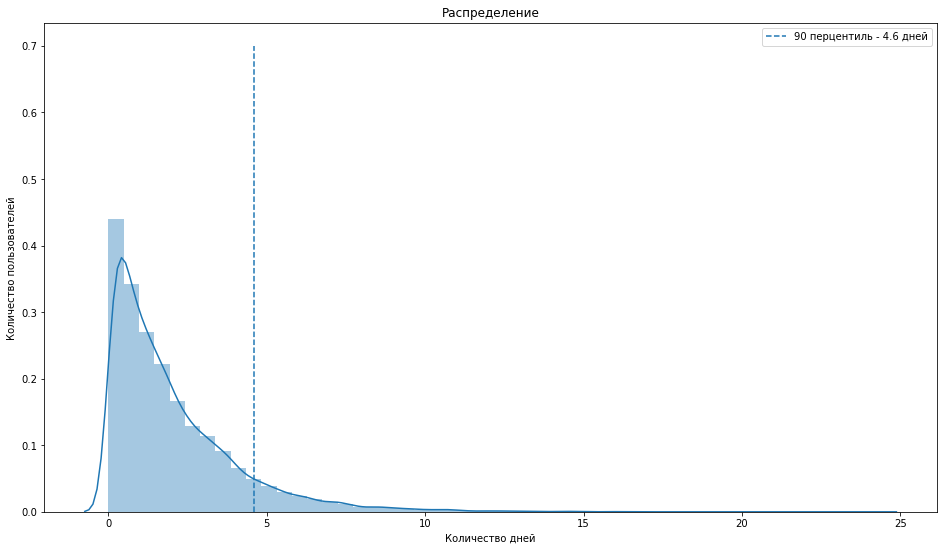

In [121]:
perc_90 = round(np.percentile(only_purchase['time_to_order'], 90),1)

plt.figure(figsize=(16,9))
sns.distplot(only_purchase['time_to_order'])
plt.vlines(perc_90,ymin = 0, ymax = 0.7, linestyle='dashed', label = f'90 перцентиль - {perc_90} дней')
plt.title('Распределение')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

In [122]:
only_purchase['created_order_in_4.6_days'] = only_purchase['time_to_order'].apply(lambda x: 1 if x < 4.6 else 0)
only_purchase 
# 1 - если сделан заказ за 4.6 дней, 0 - если нет.

,user_id,timestamp,event,test_group,registered_at,device,geo,marketing,time_to_order,created_order_in_4.6_days
28,1343452,2020-11-20 20:37:40,purchase,small_increase,2020-11-19 15:56:34,desktop,spb,organic,1.19521,1
31,1287352,2020-11-18 15:37:09,purchase,control,2020-11-13 17:30:22,mobile,msk,organic,4.92138,0
35,1276338,2020-11-27 04:30:56,purchase,control,2020-11-24 03:25:42,desktop,regions,organic,3.0453,1
57,1291792,2020-11-24 13:28:05,purchase,big_increase,2020-11-23 02:30:08,desktop,world,organic,1.45691,1
64,1397741,2020-11-17 12:13:37,purchase,control,2020-11-13 10:29:43,desktop,msk,cpc,4.07215,1
...,...,...,...,...,...,...,...,...,...,...
329530,1400795,2020-11-09 14:44:50,purchase,big_increase,2020-11-09 10:45:59,mobile,regions,cpc,0.165868,1
329533,1223473,2020-11-13 08:55:06,purchase,control,2020-11-12 14:40:09,tablet,spb,social,0.760382,1
329542,1177147,2020-11-11 22:14:44,purchase,big_increase,2020-11-11 16:09:26,desktop,regions,organic,0.253681,1
329546,1248667,2020-11-07 14:45:38,purchase,big_increase,2020-11-04 05:18:36,mobile,msk,organic,3.39377,1


In [123]:
only_purchase = pd.merge(only_purchase, purchases, how = 'left', left_on = 'user_id', right_on = 'user_id')

In [124]:
data = pd.merge(new_events,only_purchase[['user_id','event','order_sum','created_order_in_4.6_days']] ,
                     how = 'left', left_on= ['user_id','event'], right_on =['user_id','event'])

In [125]:
metrics = data.groupby('test_group', as_index=False).agg({'user_id': 'count', 'created_order_in_4.6_days': 'sum'})
metrics['conversion']=round(metrics['created_order_in_4.6_days']/metrics['user_id']*100,2)
metrics

,test_group,user_id,created_order_in_4.6_days,conversion
0,big_increase,108990,9754.0,8.95
1,control,110742,10202.0,9.21
2,small_increase,109893,9917.0,9.02


In [126]:
def segments(df, segment_columns, test_factor):
    for segment in segment_columns:
        agg_data = df.groupby(by=[test_factor, segment]).user_id.count().reset_index()
        sns.catplot(x = segment, y = 'user_id', hue = test_factor, data = agg_data, kind = 'bar', height =4, aspect = 1.5)
        

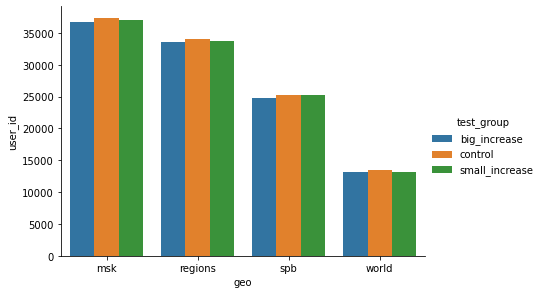

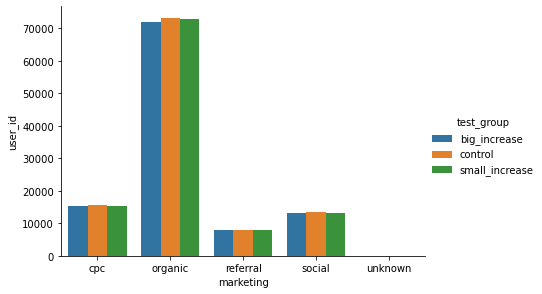

In [127]:
segments(data, ['geo','marketing'], 'test_group')

In [15]:
# сегменты равномерны

In [129]:
metrics_big_control = metrics.iloc[[0,1]]
chi2stat,pval_big_contr,table = proportion.proportions_chisquare(metrics_big_control['created_order_in_4.6_days'],
                                                       metrics_big_control['user_id'])
pval_big_contr

0.03197338295163398

In [130]:
metrics_small_control = metrics.iloc[[1,2]]
chi2stat,pval_small_control,table = proportion.proportions_chisquare(metrics_small_control['created_order_in_4.6_days'],
                                                       metrics_small_control['user_id'])
pval_small_control

0.12474487717781525

In [131]:
metrics_big_small = metrics.iloc[[0,2]]
chi2stat,pval_big_small,table = proportion.proportions_chisquare(metrics_big_small['created_order_in_4.6_days'],
                                                       metrics_big_small['user_id'])
pval_big_small

0.5407311985330518

In [132]:
results = pd.DataFrame({'Вариант сравнения': ['big vs control', 'small vs control', 'big vs small'],
                        'p-value (до поправки)': [pval_big_contr, pval_small_control, pval_big_small],
                        'Есть ли стат. значимая разница (до поправки)': [True, False, False]})
results

,Вариант сравнения,p-value (до поправки),Есть ли стат. значимая разница (до поправки)
0,big vs control,0.031973,True
1,small vs control,0.124745,False
2,big vs small,0.540731,False


In [133]:
new_results = multipletests(pvals = results['p-value (до поправки)'], alpha=0.05, method='bonferroni')

In [134]:
results['p-value (после поправки)'] = new_results[1]
results['Есть ли стат. значимая разница (после поправки)'] = new_results[0]
results

,Вариант сравнения,p-value (до поправки),Есть ли стат. значимая разница (до поправки),p-value (после поправки),Есть ли стат. значимая разница (после поправки)
0,big vs control,0.031973,True,0.095920,False
1,small vs control,0.124745,False,0.374235,False
2,big vs small,0.540731,False,1.000000,False


In [135]:
# у каждого варианта p-value > alpha,статистически значимой разницы нет, отклонить нулевую гипотезу мы не можем.

In [136]:
big_increase = only_purchase[only_purchase['test_group'] == 'big_increase']['order_sum'].dropna().values

In [137]:
small_increase = only_purchase[only_purchase['test_group'] == 'small_increase']['order_sum'].dropna().values

In [138]:
control = only_purchase[only_purchase['test_group'] == 'control']['order_sum'].dropna().values

C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


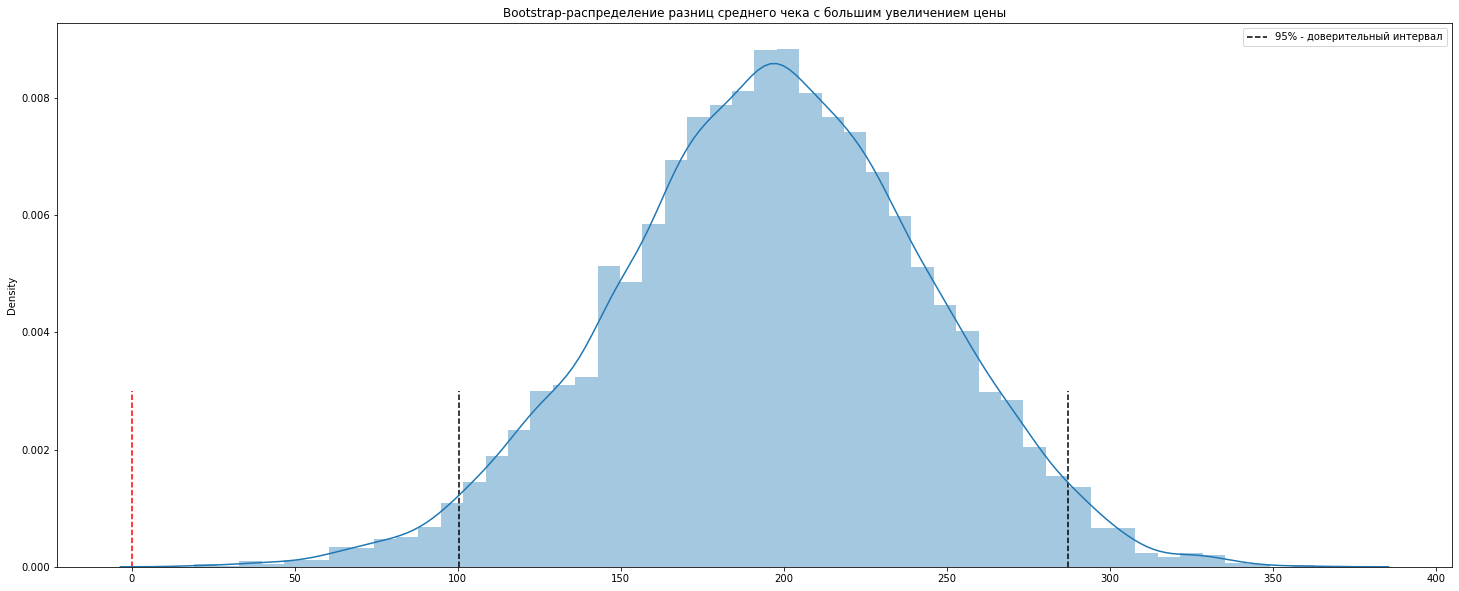

In [139]:
boot_res_1 = bs.bootstrap_ab(test = big_increase, ctrl = control,
                             stat_func = bs_stats.mean,
                             compare_func = bs_compare.difference,
                             return_distribution=True)

borders = np.percentile(boot_res_1, [2.5, 97.5])

sns.distplot(boot_res_1)
plt.title('Bootstrap-распределение разниц среднего чека с большим увеличением цены')
plt.rcParams['figure.figsize'] = (25,10)
plt.vlines(0, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'red')
plt.vlines(borders, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'black', label = '95% - доверительный интервал')
plt.legend()
plt.show()

In [94]:
# судя по графику, конверсия в тестовом варианте с большим увеличением цены статистически выше, чем в контрольном.

C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


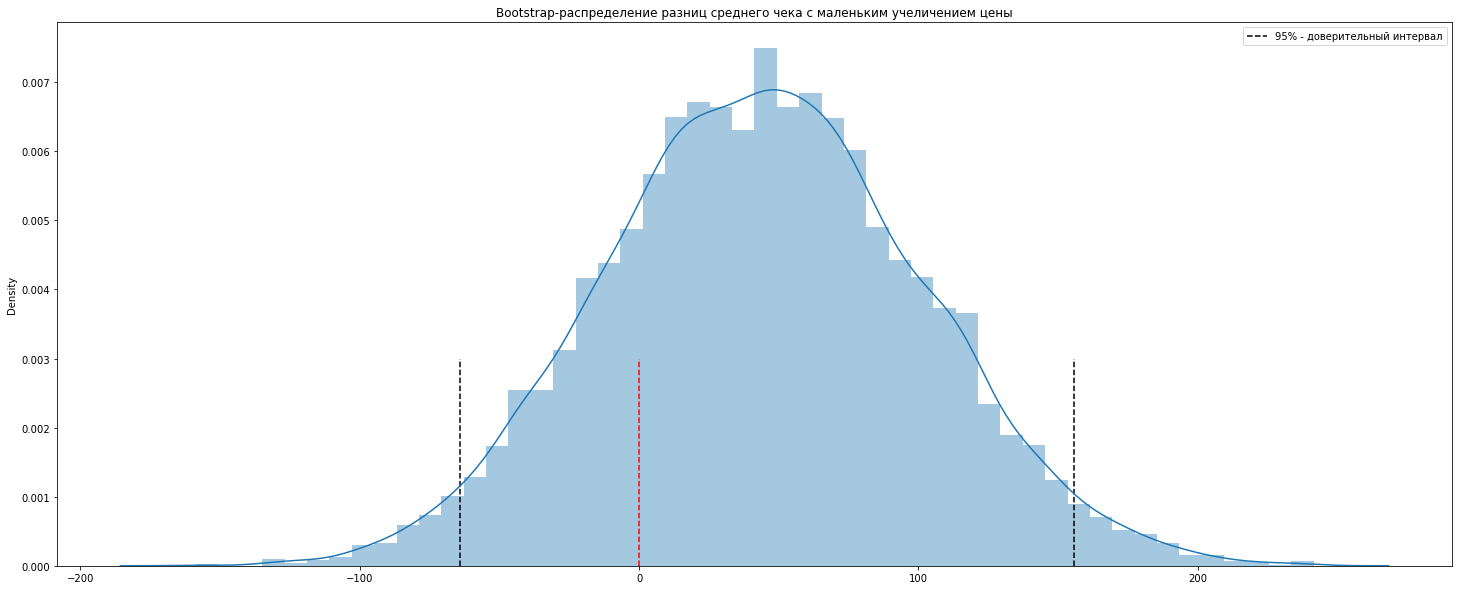

In [140]:
boot_res_2 = bs.bootstrap_ab(test = small_increase, ctrl = control,
                             stat_func = bs_stats.mean,
                             compare_func = bs_compare.difference,
                             return_distribution=True)

borders = np.percentile(boot_res_2, [2.5, 97.5])

sns.distplot(boot_res_2)
plt.title('Bootstrap-распределение разниц среднего чека с маленьким учеличением цены')
plt.rcParams['figure.figsize'] = (25,10)
plt.vlines(0, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'red')
plt.vlines(borders, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'black', label = '95% - доверительный интервал')
plt.legend()
plt.show()

In [96]:
# суля по графику нет статистически значимой разницы, при сравнении контрольной группы, и группы с небольшим увеличением цены

In [109]:
metrics

,test_group,user_id,created_order_in_4.6_days,conversion
0,big_increase,108990,9754.0,8.95
1,control,110742,10202.0,9.21
2,small_increase,109893,9917.0,9.02


In [141]:
chipower = smp.GofChisquarePower()

In [142]:
conversion_control = metrics['conversion'].values[1]/100
conversion_big = metrics['conversion'].values[0]/100
conversion_small = metrics['conversion'].values[2]/100
nobs = min(metrics['user_id'])

In [143]:
def chi2_effect_size(x, y):
    return np.sqrt(((x - y) **2 / x))

In [144]:
chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_small),
                     nobs = nobs,
                     alpha = pval_small_control,
                     power = None)

0.7027014278653085

In [102]:
# при сравнении контрольной группы и группы с не большим увеличением цены мощность оказалась ниже 80%

In [145]:
chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_big),
                     nobs = nobs,
                     alpha = pval_big_contr,
                     power = None)

0.7528962037162132

In [181]:
# при сравнении контрольной группы и группы с большим увеличением цены мощность оказалась ниже 80%

In [146]:
power = 0.8

In [147]:
size_of_each_testgroup = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_big),
                     nobs = None,
                     alpha = pval_big_contr,
                     power = power)
print('Необходимый размер выборки для эксперимента - {:.0f}'.format(2*size_of_each_testgroup))

Необходимый размер выборки для эксперимента - 243012


In [148]:
size_of_each_testgroup = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_small),
                     nobs = None,
                     alpha = pval_small_control,
                     power = power)
print('Необходимый размер выборки для эксперимента - {:.0f}'.format(2*size_of_each_testgroup))

Необходимый размер выборки для эксперимента - 288204


In [ ]:
# Результаты теста показали, что увеличение цены не повлияет на конверсию в обоих случаях
# однако большое увеличение цены увеличит доход , при этом не уменьшая конверсию на продукцию.
# Но для лучшей точности эксперемента, необходимо увеличить размер выборки.